# Generative models on HSMusic

### Baselines
* Crop 100 frames and process data as images (instead of using sequential models such as RNN, LSTM)
* Try autoencoders (fully connected and CNN), additive noise model, medGAN, copula
* Pre-train on all data (130,000 midi files) -> save as NPY
* Train on subset of data (only specific musicians)
* Data augmentation: random transposition from -12 to +12
* Binarization: try various threshold if the output contains only zeros

In [1]:
 %load_ext autoreload
%autoreload 2
from generators import *
import sys
sys.path.append('../')
import hsmusic
import numpy as np
from tqdm import tqdm
import autopandas as apd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [31]:
def show(example):
    for i in range(1):
        a = example[:,:,i]
        a = a.reshape(100, 78)
        plt.imshow(a)

In [111]:
sequence_length = 100
data = hsmusic.get_data(['mozart', 'bach', 'victoria']) #, [500, 500])
data = crop_data_bis(data, sequence_length=sequence_length)
n = data.shape[0]
print(data.shape)

Reading midi files...


 18%|█▊        | 461/2571 [07:25<1:00:03,  1.71s/it]

Failed to read /mnt/Documents/music-gen/hsmusic/data/reddit/unknown/4/40mozart.mid.
Bad header in MIDI file.


 20%|█▉        | 502/2571 [07:51<14:22,  2.40it/s]  

Failed to read /mnt/Documents/music-gen/hsmusic/data/umaes/baroque/bach_motete_3_jesu_meine_freude.mid.
Bad header in MIDI file.


 20%|█▉        | 507/2571 [07:52<09:03,  3.80it/s]

Failed to read /mnt/Documents/music-gen/hsmusic/data/umaes/baroque/bach_244_o_mensch.mid.
Bad header in MIDI file.


 20%|█▉        | 509/2571 [07:53<10:49,  3.18it/s]

Failed to read /mnt/Documents/music-gen/hsmusic/data/umaes/baroque/bach_o_jesu_christ_meins_lebens_licht.mid.
Bad header in MIDI file.


 20%|██        | 515/2571 [07:54<11:45,  2.91it/s]

Failed to read /mnt/Documents/music-gen/hsmusic/data/umaes/baroque/bach_motete_5_komm_jesu_komm.mid.
Bad header in MIDI file.


 82%|████████▏ | 2116/2571 [17:19<06:37,  1.15it/s]

Failed to read /mnt/Documents/music-gen/hsmusic/data/reddit/unknown/b/b/brandenberg_concerto_no3_bach.mid.
Bad header in MIDI file.


 87%|████████▋ | 2226/2571 [18:20<03:33,  1.62it/s]

Failed to read /mnt/Documents/music-gen/hsmusic/data/reddit/unknown/v/v/variations_on_a_bach_invention.mid.
must be str, not bytes


100%|█████████▉| 2569/2571 [21:44<00:00,  2.95it/s]

Failed to read /mnt/Documents/music-gen/hsmusic/data/reddit/unknown/v/v/victoria.mid.
Bad header in MIDI file.


100%|██████████| 2571/2571 [21:45<00:00,  1.97it/s]


(1725, 100, 78, 2)


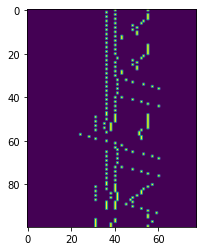

In [112]:
show(data[6])

# Fully connected architecture

In [113]:
# Reshape data
data_reshaped = np.reshape(data, (n, sequence_length*78*2))
# loss='mse', 'binary_crossentropy'
model = apd.generators.VAE(input_dim=(sequence_length*78* 2), layers=[480], latent_dim=120, loss='nll', architecture='fully', optimizer='adam')
vae, encoder, decoder = model.autoencoder, model.encoder, model.decoder
#print(vae.summary())
model.fit(data_reshaped, epochs=50)

Train on 1725 samples
Epoch 1/50
1725/1725 [==============================] - 2s 1ms/sample - loss: 6.4888
Epoch 2/50
1725/1725 [==============================] - 1s 416us/sample - loss: 3.0267
Epoch 3/50
1725/1725 [==============================] - 1s 414us/sample - loss: 2.9166
Epoch 4/50
1725/1725 [==============================] - 1s 418us/sample - loss: 2.8802
Epoch 5/50
1725/1725 [==============================] - 1s 403us/sample - loss: 2.8717
Epoch 6/50
1725/1725 [==============================] - 1s 395us/sample - loss: 2.8738
Epoch 7/50
1725/1725 [==============================] - 1s 413us/sample - loss: 2.8681
Epoch 8/50
1725/1725 [==============================] - 1s 418us/sample - loss: 2.8676
Epoch 9/50
1725/1725 [==============================] - 1s 423us/sample - loss: 2.8683
Epoch 10/50
1725/1725 [==============================] - 1s 421us/sample - loss: 2.8680
Epoch 11/50
1725/1725 [==============================] - 1s 441us/sample - loss: 2.8703
Epoch 12/50
1725/1725

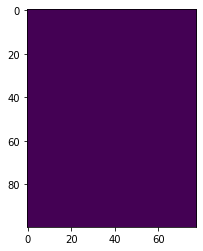

In [116]:
# generate output
s = np.array(model.sample(1))
s = binarize(s)
s = np.reshape(s, (100, 78, 2))
show(s)

In [101]:
# save
hsmusic.to_midi(s, 'output/fully.mid')

# CNN architecture

In [117]:
sdata = simplify_data(data)

In [118]:
sdata = np.reshape(sdata, (n, sequence_length, 78, 1))

In [120]:
model = apd.generators.VAE(input_dim=(sequence_length, 78, 1), layers=[36], latent_dim=12, loss='nll', architecture='cnn', optimizer='adam')
vae, encoder, decoder = model.autoencoder, model.encoder, model.decoder
#print(vae.summary())
model.fit(sdata, epochs=10)

/usr/local/lib/python3.6/dist-packages/autopandas/generators/vae.py:103: UserWarning: strides argument is currently not implemented.
  warn('strides argument is currently not implemented.')


Train on 1725 samples
Epoch 1/10
1725/1725 [==============================] - 3s 2ms/sample - loss: 22.6054
Epoch 2/10
1725/1725 [==============================] - 1s 810us/sample - loss: 11.6821
Epoch 3/10
1725/1725 [==============================] - 1s 809us/sample - loss: 10.3718
Epoch 4/10
1725/1725 [==============================] - 1s 810us/sample - loss: 10.1539
Epoch 5/10
1725/1725 [==============================] - 1s 809us/sample - loss: 9.9909
Epoch 6/10
1725/1725 [==============================] - 1s 811us/sample - loss: 9.8460
Epoch 7/10
1725/1725 [==============================] - 1s 811us/sample - loss: 9.7844
Epoch 8/10
1725/1725 [==============================] - 1s 810us/sample - loss: 9.7637
Epoch 9/10
1725/1725 [==============================] - 1s 815us/sample - loss: 9.7380
Epoch 10/10
1725/1725 [==============================] - 1s 813us/sample - loss: 9.7310


/usr/local/lib/python3.6/dist-packages/autopandas/generators/autoencoder.py:188: UserWarning: Impossible to cast sampled data to autopandas.AutoData
  warn('Impossible to cast sampled data to autopandas.AutoData')


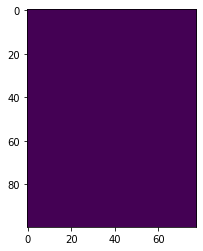

In [122]:
# generate output
s = model.sample(1)
s = binarize(s)
s = np.reshape(s, (100, 78, 1))
zeros = np.zeros((100, 78, 1))
s = np.concatenate([s, zeros], axis=2)
show(s)

In [58]:
hsmusic.to_midi(s, 'output/cnn.mid')

# Additive Noise Model

In [125]:
# Reshape data
data_reshaped = apd.AutoData(np.reshape(data, (n, sequence_length*78*2)))
# loss='mse', 'binary_crossentropy'
model = apd.generators.ANM()
#print(vae.summary())
model.fit(data_reshaped)

In [130]:
# generate output
s = np.array(model.sample(1))
s = binarize(s)
s = np.reshape(s, (100, 78, 2))
show(s)

In [ ]:
hsmusic.to_midi(s, 'output/anm.mid')

# MedGAN

In [121]:
# ...